<a href="https://colab.research.google.com/github/pen1064/OhCrack/blob/main/RoadCrack_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pip install barbar

In [78]:
import os 
import numpy as np
import glob
from barbar import Bar
from xml.etree import ElementTree as ET
import pandas as pd
import plotly.express as px
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision
from torchvision import transforms, datasets, models
import time
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
iamge_directory = '/content/gdrive/MyDrive/Crack/Japan/images/'
JDATA = {'filename':[], 'dim':[], 'type':[], 'bndbx':[]}
for file in glob.glob('/content/gdrive/MyDrive/Crack/Japan/annotations/xmls/*.xml'):
  tree = ET.parse(file)
  root = tree.getroot() 
  filename = root.find('filename').text
  dim =[int(a.text) for a in root.find('size')]
  for i in root.findall('object'):
      JDATA['filename'] += [iamge_directory+filename]
      JDATA['dim'] += [dim]
      JDATA['type'] += [i.find('name').text]
      JDATA['bndbx'] += [[int(a.text) for a in i.find('bndbox')]]


In [74]:
#train_df = pd.DataFrame.from_dict(JDATA) 
#train_df.head(3)
#train_df.to_csv('/content/gdrive/MyDrive/Crack/Japan/train_df.csv', index=False)
train_df = pd.read_csv('/content/gdrive/MyDrive/Crack/Japan/train_df.csv')
train_df['bndbx'] = train_df['bndbx'].apply(lambda z: eval(z))
train_df['dim'] = train_df['dim'].apply(lambda z: eval(z))
train_df.dtypes
train_df.head(3)

,filename,dim,type,bndbx
0,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",D40,"[277, 521, 324, 535]"
1,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",D40,"[22, 437, 48, 470]"
2,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",D50,"[257, 536, 360, 583]"


In [6]:
fig = px.pie(train_df, "type")
fig.update_layout(height=400, width = 400)
fig.show()

In [76]:
train_df['type'] = pd.Categorical(train_df['type'])
crack_type = dict( enumerate(train_df['type'].cat.categories ) )
train_df['type'] = train_df['type'].cat.codes
train_df.head(3)

,filename,dim,type,bndbx
0,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",3,"[277, 521, 324, 535]"
1,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",3,"[22, 437, 48, 470]"
2,/content/gdrive/MyDrive/Crack/Japan/images/Jap...,"[600, 600, 3]",6,"[257, 536, 360, 583]"


In [77]:
print(crack_type)

{0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40', 4: 'D43', 5: 'D44', 6: 'D50'}


In [9]:
Bad_Data = []
for i in range(len(train_df)):
  z = list(train_df.loc[i, 'bndbx'])
  if z[0] >= z[2] or z[1] >= z[3]:
    Bad_Data.append(i)
print(Bad_Data)

[24650]


In [10]:
[train_df.drop(index = i, axis = 0, inplace=True) for i in Bad_Data]
train_df.reset_index(inplace=True)

In [5]:
class MaskDataset(object):
    def __init__(self, df):
        self.transforms = transforms
        self.df = df
        self.imgs =df['filename'].unique()

    def __getitem__(self, idx): 
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        img = transforms.ToTensor()(img)

        target={}
        target['boxes'] = torch.as_tensor(self.df[self.df['filename'] == self.imgs[idx]]['bndbx'].to_list(), dtype=torch.float32)
        target['labels'] = torch.as_tensor(self.df[self.df['filename'] == self.imgs[idx]]['type'].to_list(), dtype=torch.int64)
 
        return img, target

    def __len__(self): 
        return len(self.imgs)


def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
dataset = MaskDataset(train_df)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [11]:
train_dataset = MaskDataset(train_df)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)

In [ ]:
#test_dataset = MaskDataset(test_df)
#test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [12]:
def get_model_instance_segmentation(num_classes, **kwargs):
    model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=num_classes, pretrained=False, pretrained_backbone=True)#take backbone
    if 'weights' in kwargs:
      if torch.cuda.is_available():
        model.load_state_dict(torch.load(kwargs['weights']))
      else:
        model.load_state_dict(torch.load(kwargs['weights'], map_location=torch.device('cpu')))
    return model

In [14]:
#model = get_model_instance_segmentation(7) #no need background classes because it is using sigmoid not softmax
model = get_model_instance_segmentation(7, weights='/content/gdrive/MyDrive/Crack/meowre_retina_23.pt') 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,momentum=0.9, weight_decay=0.0005)
losses_epoch = [3539, 2450, 2047, 1815, 1653, 1525, 1426, 1343, 1269, 1201, 1164, 1115, 1063, 1000, 1005, 968, 974, 887, 838, 799, 783, 750, 
                723, 686, 657, 647, 646, 626, 609, 617, 610, 556, 532,523, 616, 539, 515, 479, 550, 541]
for epoch in range(num_epochs):
    start = time.time()
    print(start)
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in Bar(data_loader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
        
    print(f'epoch : {epoch+25}, Loss : {epoch_loss}, time : {time.time() - start}')
    losses_epoch.append(epoch_loss)
    print(losses_epoch)
    
    if epoch%2 == 0:
      torch.save(model.state_dict(),'/content/gdrive/MyDrive/Crack/meowre_retina_{}.pt'.format(epoch+25))

1651674775.8381593
9712/9712: [===============================>] - ETA 26.1s
epoch : 25, Loss : 645.5709838867188, time : 3650.3526690006256
[3539, 2450, 2047, 1815, 1653, 1525, 1426, 1343, 1269, 1201, 1164, 1115, 1063, 1000, 1005, 968, 974, 887, 838, 799, 783, 750, 723, 686, 657, 647, tensor(645.5710, device='cuda:0', grad_fn=<AddBackward0>)]
1651678428.2945132
9712/9712: [===============================>] - ETA 0.3s
epoch : 26, Loss : 626.1691284179688, time : 1012.8301889896393
[3539, 2450, 2047, 1815, 1653, 1525, 1426, 1343, 1269, 1201, 1164, 1115, 1063, 1000, 1005, 968, 974, 887, 838, 799, 783, 750, 723, 686, 657, 647, tensor(645.5710, device='cuda:0', grad_fn=<AddBackward0>), tensor(626.1691, device='cuda:0', grad_fn=<AddBackward0>)]
1651679441.1276624
9712/9712: [===============================>] - ETA 0.3s
epoch : 27, Loss : 609.8001708984375, time : 1012.5302395820618
[3539, 2450, 2047, 1815, 1653, 1525, 1426, 1343, 1269, 1201, 1164, 1115, 1063, 1000, 1005, 968, 974, 887, 838,

In [13]:
model = get_model_instance_segmentation(7, weights='/content/gdrive/MyDrive/Crack/meowre_retina_31.pt') #no need background classes because it is using sigmoid not softmax
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
"""
iamge_directory = '/content/gdrive/MyDrive/Crack/Japan/Test/images/'
JDATA = {'filename':[], 'dim':[], 'type':[], 'bndbx':[]}
for file in glob.glob('/content/gdrive/MyDrive/Crack/Japan/Test/annotations/xmls/*.xml'):
  tree = ET.parse(file)
  root = tree.getroot() 
  filename = root.find('filename').text
  dim =[int(a.text) for a in root.find('size')]
  for i in root.findall('object'):
      JDATA['filename'] += [iamge_directory+filename]
      JDATA['dim'] += [dim]
      JDATA['type'] += [i.find('name').text]
      JDATA['bndbx'] += [[int(a.text) for a in i.find('bndbox')]]
"""

In [ ]:
#test_df = pd.DataFrame.from_dict(JDATA) 
#test_df.head(3)
#test_df.to_csv('/content/gdrive/MyDrive/Crack/Japan/test_df.csv', index=False)

In [14]:
test_df = pd.read_csv('/content/gdrive/MyDrive/Crack/Japan/test_df.csv')
test_df['bndbx'] = test_df['bndbx'].apply(lambda z: eval(z))
test_df['dim'] = test_df['dim'].apply(lambda z: eval(z))
test_df.dtypes
test_df.head(3)

Bad_Data = []
for i in range(len(test_df)):
  z = list(test_df.loc[i, 'bndbx'])
  if z[0] >= z[2] or z[1] >= z[3]:
    Bad_Data.append(i)
print(Bad_Data)

[test_df.drop(index = i, axis = 0, inplace=True) for i in Bad_Data]
test_df.reset_index(inplace=True)

test_df['type'] = pd.Categorical(test_df['type'])
test_df['type'] = test_df['type'].cat.codes
test_df.head(3)

test_dataset = MaskDataset(test_df)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

[24619]


In [15]:
def model_predict(model, img, threshold):
  model.eval()
  preds = model(img)
  #print(preds)
  #print(preds[0])
  for ind_p in range(len(preds)):
    idxx = []
    for idx_s, score in enumerate(preds[ind_p]['scores']):
      if score > threshold:
        idxx.append(idx_s)

    preds[ind_p]['boxes'] = preds[ind_p]['boxes'][idxx]
    preds[ind_p]['scores'] = preds[ind_p]['scores'][idxx]
    preds[ind_p]['labels'] = preds[ind_p]['labels'][idxx]
  return preds

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = model_predict(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device(device)) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 2428/2428 [1:04:38<00:00,  1.60s/it]


In [16]:
def calculate_IoU(box1, box2):
  intersect_w = torch.min(box1[2], box2[2]) - torch.max(box1[0], box2[0])
  intersect_h = torch.min(box1[3], box2[3]) - torch.max(box1[1], box2[1])
  intersect_area = intersect_w*intersect_h
  union_area = (box1[2] - box1[0])*(box1[3] - box1[1]) + (box2[2] - box2[0])*(box2[3] - box2[1]) - intersect_area
  return intersect_area/union_area

# Precision = true_positive/predicted_positive
def evaluate_scores(p, a, num_classes, iou_threshold):
  scores = []
  for c in range(num_classes):
    num_i = 0
    gt = a['boxes'][torch.isin(a['labels'], c)]
    p_bx, p_scores = p['boxes'][torch.isin(p['labels'],c)], p['scores'][torch.isin(p['labels'],c)]
    
    if len(gt) == 0 or len(p_bx) == 0:
      scores.append(0)
    elif len(gt) == 0 and len(p_bx) != 0:
      scores.append(0)
      num_i += 1
    else:
      s = 0
      for pbx_ind, pbx in enumerate(p_bx):
        for gtt in gt:
          iou = calculate_IoU(pbx, gtt)
          #print('iou', iou)
          if iou > iou_threshold:
            s+= float(p_scores[pbx_ind])
      #print(s)
      scores.append(s/len(p_scores))
  return scores


iou_threshold = 0.75

# Calculate average precision 
precisions = []
for batch_num, p_batch in enumerate(preds_adj_all):#preds_adj_all:
  # in each batch
  for pi, p in enumerate(p_batch):
    # in each pic
    scores = evaluate_scores(p, annot_all[batch_num][pi], 7, iou_threshold)
    #print(scores)
    precisions.append(scores)
    
pms = np.array(precisions)
print([np.sum(pms[:,i])/len(np.nonzero(pms[:,i])[0])  for i in range(7)])

[0.8377569988449534, 0.6341449807838158, 0.8353168209868658, 0.8944889143430446, 0.839397589163122, 0.8764083202505211, 0.8768166112428727]


torch.Size([1, 3, 600, 600])
[{'boxes': tensor([[308.3361,  63.3041, 423.9742, 132.9449],
        [459.9587, 206.2116, 575.5909, 314.1115]], device='cuda:0'), 'scores': tensor([0.9913, 0.9596], device='cuda:0'), 'labels': tensor([5, 0], device='cuda:0')}]
1
<class 'list'>


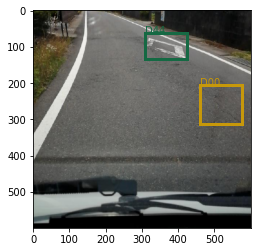

torch.Size([1, 3, 600, 600])
[{'boxes': tensor([[384.2648, 428.4573, 480.6576, 454.2752],
        [489.2463, 388.0445, 564.3354, 409.0924]], device='cuda:0'), 'scores': tensor([0.9855, 0.9679], device='cuda:0'), 'labels': tensor([6, 6], device='cuda:0')}]
1
<class 'list'>


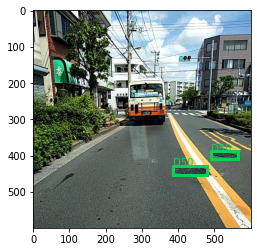

In [81]:
FILES = [r'/content/gdrive/MyDrive/Crack/Japan/Test/images/Japan_004903.jpg', r'/content/gdrive/MyDrive/Crack/Japan/Test/images/Japan_000142.jpg']
for file in FILES:
  img1 = Image.open(file).convert("RGB")                  
  img = transforms.ToTensor()(img1)
  img = img.unsqueeze(0)
  print(img.shape)

  img = img.to(device)
  with torch.no_grad():
    p = model_predict(model, img, 0.9)
    
  print(p)
  print(len(p))

  fig, ax = plt.subplots()
  ax.imshow(img1)

  colors = ['#C7980A', '#F4651F', '#82D8A7', '#CC3A05', '#575E76', '#156943', '#0BD055', '#ACD338']
  category = {0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40', 4: 'D43', 5: 'D44', 6: 'D50'}
  for i, pp in enumerate(p):
   #print(pp)

    for ii, bb in enumerate(pp['boxes']):
      b = bb.cpu().numpy()
      if type(pp['labels']) is not list:
        pp['labels'] = list(pp['labels'])
        print(type(pp['labels']))
      if pp['labels'][ii] == 0:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[0], facecolor='none')
        ax.annotate(category[0], (b[0], b[1]), color=colors[0])
      elif pp['labels'][ii] == 1:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[1], facecolor='none')
        ax.annotate(category[1], (b[0], b[1]), color=colors[1])
      elif pp['labels'][ii] == 2:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[2], facecolor='none')
        ax.annotate(category[2], (b[0], b[1]), color=colors[2])
      elif pp['labels'][ii] == 3:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[3], facecolor='none')
        ax.annotate(category[3], (b[0], b[1]), color=colors[3])
      elif pp['labels'][ii] == 4:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[4], facecolor='none')
        ax.annotate(category[4], (b[0], b[1]), color=colors[4])
      elif pp['labels'][ii] == 5:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[5], facecolor='none')
        ax.annotate(category[5], (b[0], b[1]), color=colors[5])
      else:
        rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[6], facecolor='none')
        ax.annotate(category[6], (b[0], b[1]), color=colors[6])
      ax.add_patch(rect) 
    plt.show()


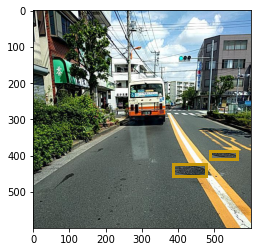

In [65]:
# show the original annotation
fn = '/content/gdrive/MyDrive/Crack/Japan/Test/images/Japan_000142.jpg'
img = Image.open(fn).convert("RGB")
bdxs = [[489, 388, 562, 409], [385, 424, 478, 457]]
fig, ax = plt.subplots()
ax.imshow(img)
for b in bdxs:
   rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor=colors[0], facecolor='none')
   ax.add_patch(rect) 
plt.show()
